In [1]:
import os
import re
import numpy as np
import pandas as pd
import json
from pathlib import Path
from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_json(filepath: str):
    with open(filepath) as file:
        data = json.load(file)
    return data

In [3]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

PERIODIC_TABLE_PATH = os.path.join(
    os.path.dirname(os.getcwd()), "data_preprocessing/periodic_table_info.json",
)
PERIODIC_TABLE_INFO = load_json(PERIODIC_TABLE_PATH)

# Loading Data

In [4]:
def parse_structure_files(data_path, encoding):
    structure_files = []
    p = Path(data_path)
    for struct_dir in p.iterdir():
        if not struct_dir.is_dir():
            continue
        for file in struct_dir.glob(f"*{encoding}*.csv"):
            structure_name = os.path.basename(struct_dir)

            # Parsing the structure name to get the elements and their number
            elts = re.findall("[A-Z][^A-Z]*", structure_name)
            elements_nbrs = defaultdict(int)
            for elt in elts:
                atom_num = re.findall("\d+|\D+", elt)
                if len(atom_num) == 1:
                    elements_nbrs[elt] += 1
                else:
                    elements_nbrs[elt[0]] += int(elt[1])

            # Skip Lantanides
            isLant = False
            for elt in elements_nbrs.keys():
                if PERIODIC_TABLE_INFO[elt]["PTC"] == "Lant":
                    isLant = True
            if not isLant:
                structure_files.append(file)
            
    return structure_files

In [5]:
encoding = "column_mass"
structure_files = parse_structure_files(DATA_DIR, encoding)

In [6]:
df = pd.concat([pd.read_csv(filepath, index_col=0) for filepath in structure_files], ignore_index=True)

In [7]:
cols_raw = list(df.columns)
cols_trash = ['converged', "n_iterations", "delta_E", "fermi", "total_energy"]
cols_independent = ['time']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [8]:
X_raw = df[cols_dependent][df["converged"]]
y_raw = np.abs(df[cols_independent][df["converged"]]).squeeze()

In [9]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,accuracy,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,27220.000000,27220.000000,27220.000000,2.722000e+04,27220.000000,27220.000000,27220.000000,27220.000000,27220.000000,27220.000000,...,27220.000000,27220.000000,27220.00000,27220.000000,27220.000000,27220.000000,27220.000000,27220.000000,27220.000000,27220.0
mean,245.143277,5.796841,58.043718,2.978053e-10,0.048874,0.105010,0.037975,0.023637,0.054672,0.014491,...,0.056202,0.078374,0.02835,0.046917,0.046518,0.091231,0.097449,0.085025,0.050835,0.0
std,89.365781,2.843200,24.017127,2.817140e-10,0.185574,0.261876,0.143210,0.121163,0.204980,0.068262,...,0.206147,0.237286,0.13123,0.172852,0.163866,0.211187,0.219180,0.185315,0.180437,0.0
min,100.000000,2.000000,20.000000,1.600000e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,35.000000,6.000000e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,55.000000,1.900000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,80.000000,4.900000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,1.000000e-09,1.000000,1.000000,0.741626,0.841555,1.000000,0.339697,...,1.000000,1.000000,1.00000,0.803422,0.967155,1.000000,0.895814,0.637235,0.833172,0.0


# Train-Test-Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [11]:
linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [12]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [13]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [14]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [15]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [16]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [17]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:9.9277E+09	test:7.1815E+09
MAE:	train:4.4985E+04	test:4.4067E+04
MAPE:	train:2.3162E+01	test:2.3567E+01
Done!

Evaluating Random Forest...
MSE:	train:1.2294E+08	test:4.3203E+08
MAE:	train:2.7977E+03	test:5.8336E+03
MAPE:	train:6.9576E-02	test:1.4533E-01
Done!

Evaluating XGBoost...
MSE:	train:8.4567E+06	test:5.6809E+08
MAE:	train:1.3972E+03	test:5.8360E+03
MAPE:	train:2.8566E-01	test:5.2555E-01
Done!



# Visualization

Text(0.5, 0, 'ecutwfc')

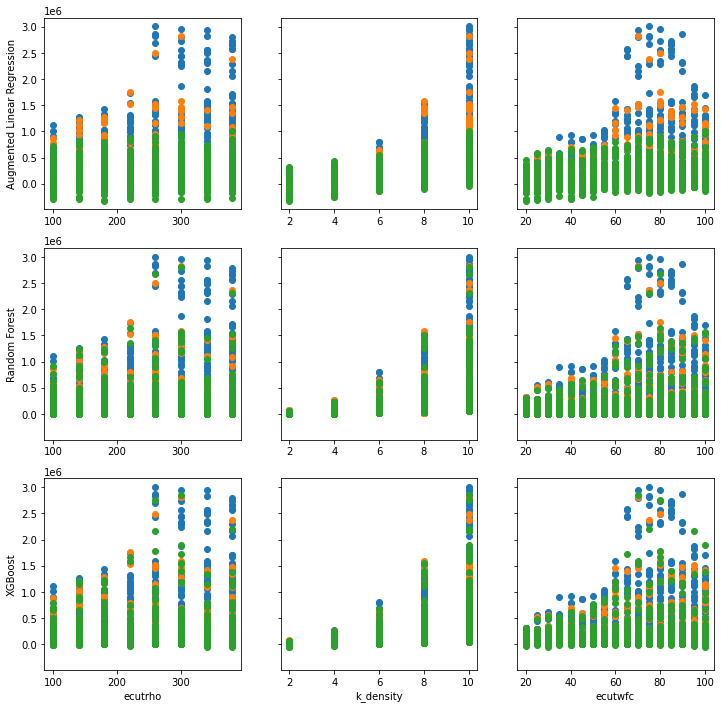

In [18]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

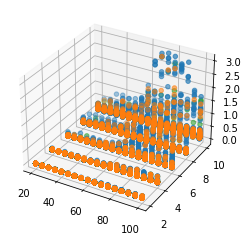

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))